In [29]:
import pickle
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.style as style

from copy import deepcopy
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, SpectralClustering, MeanShift, estimate_bandwidth
from itertools import cycle
from scipy.cluster.hierarchy import dendrogram, linkage  

%matplotlib inline
%config InlineBackend.figure_format = 'svg'
style.use('fivethirtyeight')

In [18]:
pd.options.display.float_format = '{:,.4f}'.format

plt.rc('figure', figsize=(10.0, 5.0))
matplotlib.rcParams.update({'font.size': 22})

# Make numpy outputs easier to read
np.set_printoptions(precision=3, formatter={'float': '{: 8.3f}'.format})

In [10]:
with open('./data/processed/answer_time_series2.pkl', 'rb') as picklefile:
    answer_time_series = pickle.load(picklefile)

In [11]:
answer_time_series.head()

,id,m_201701,m_201702,m_201703,m_201704,m_201705,m_201706,m_201707,m_201708,m_201709,m_201710,m_201711,m_201712
1,3,0,0,1,0,0,0,0,0,0,0,0,0
2,9,0,0,1,0,0,0,0,0,0,0,0,0
3,13,2,5,0,0,0,0,0,0,0,0,0,0
4,22,0,0,0,0,0,0,0,0,0,6,2,0
5,33,1,0,1,2,1,0,1,1,1,2,1,1


In [12]:
answer_time_series.set_index('id', inplace=True)

In [13]:
def normalizeByRow(df):
    df_norm = df.values/df.values.sum(axis=1)[:,np.newaxis]
    return pd.DataFrame(df_norm, columns=df.columns, index=df.index)

Text(0.5,1,'Histogram of user answer std')

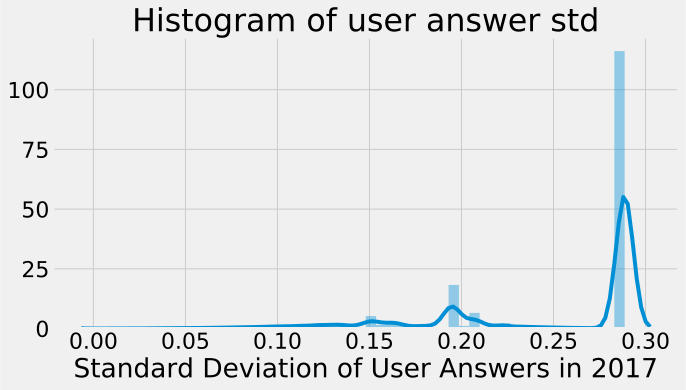

In [14]:
answerer_norm = answer_time_series.values/answer_time_series.values.sum(axis=1)[:,np.newaxis]
answerer_norm = pd.DataFrame(answerer_norm, columns=answer_time_series.columns, index=answer_time_series.index)
answerer_norm['std'] = answerer_norm.std(axis=1)
sns.distplot(answerer_norm['std'])
plt.xlabel('Standard Deviation of User Answers in 2017')
plt.title('Histogram of user answer std')

In [16]:
def detectChanges(values, window):
    status_dict = {True:'Inactive', False:'Active'}
    changes = 0
    track_status = []
    status = (np.sum([value!=0 for value in values[:window]]) == 0)
    track_status.append(status_dict[status])
    for index in range(1, len(values)-window+1):
        new_status = (np.sum([value!=0 for value in values[index:index+window]]) == 0)
        if (new_status != status):
            changes = changes + 1
            status = new_status
            track_status.append(status_dict[status])
    return changes, tuple(track_status)

In [16]:
answerer_norm.head()

,m_201701,m_201702,m_201703,m_201704,m_201705,m_201706,m_201707,m_201708,m_201709,m_201710,m_201711,m_201712,std
id,,,,,,,,,,,,,
3,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2887
9,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2887
13,0.2857,0.7143,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.2150
22,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.7500,0.2500,0.0000,0.2219
33,0.0833,0.0000,0.0833,0.1667,0.0833,0.0000,0.0833,0.0833,0.0833,0.1667,0.0833,0.0833,0.0503


## Check if a window of 4,5,6 months is sufficient to determine if user has churned

In [16]:
 answerer_norm.shape

(535679, 15)

In [26]:
def establishChurnWindow(df, window_size_list):
    for window in window_size_list:
        df[['changes','change_history']]  = df.apply(lambda x:pd.Series(list(detectChanges(x[:12], window)), index=['changes','change_history']), axis=1)
        change_count = df.groupby(['changes', 'change_history'])['m_201701'].count().reset_index().rename(columns = {'m_201701':'count'})
        relapse_row = 0
        for i in range(change_count.shape[0]):
            if (len(change_count.iloc[i, 1]) > 2):
                relapse_row = i
                break
        print (change_count)
        relapse_rate = change_count.iloc[relapse_row:]['count'].sum()/change_count.iloc[:]['count'].sum()
        print('Total percentage of miss classification with window size {0} is:{1:0.2f}'.format(window, relapse_rate))
    return

In [18]:
establishChurnWindow(answerer_norm, [3,4,5,6])

    changes                                     change_history   count
0         0                                          (Active,)   15827
1         1                                 (Active, Inactive)  131705
2         1                                 (Inactive, Active)  116235
3         2                         (Active, Inactive, Active)   28656
4         2                       (Inactive, Active, Inactive)  199288
5         3               (Active, Inactive, Active, Inactive)   20665
6         3               (Inactive, Active, Inactive, Active)   17173
7         4       (Active, Inactive, Active, Inactive, Active)    2881
8         4     (Inactive, Active, Inactive, Active, Inactive)    3084
9         5  (Active, Inactive, Active, Inactive, Active, I...     105
10        5  (Inactive, Active, Inactive, Active, Inactive,...      60
Total percentage of miss classification with window size 3 is:0.51
   changes                                change_history   count
0        0      

## Limit the analysis to top answerers

In [8]:
top_answerer = answer_time_series[answer_time_series.sum(axis=1)>=24]
top_answerer_norm = normalizeByRow(top_answerer)

In [27]:
top_answerer_norm.drop(['changes', 'change_history'], axis=1, inplace=True)

In [28]:
top_answerer_norm.head()

,m_201701,m_201702,m_201703,m_201704,m_201705,m_201706,m_201707,m_201708,m_201709,m_201710,m_201711,m_201712
id,,,,,,,,,,,,
51,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
152,0.0000,0.0000,0.1786,0.0000,0.0000,0.0000,0.0000,0.0000,0.7143,0.1071,0.0000,0.0000
267,0.0328,0.0246,0.0902,0.0820,0.1066,0.1967,0.0738,0.2049,0.0410,0.0000,0.0984,0.0492
369,0.0980,0.0392,0.0000,0.0000,0.0196,0.0588,0.0392,0.2353,0.0784,0.1373,0.2353,0.0588
476,0.0426,0.0452,0.0426,0.0612,0.0957,0.1090,0.1197,0.1144,0.1064,0.0931,0.0798,0.0904


In [29]:
establishChurnWindow(top_answerer_norm, [3,4,5,6])

   changes                                     change_history  count
0        0                                          (Active,)   8802
1        1                                 (Active, Inactive)   2374
2        1                                 (Inactive, Active)   3361
3        2                         (Active, Inactive, Active)   2281
4        2                       (Inactive, Active, Inactive)   1076
5        3               (Active, Inactive, Active, Inactive)    357
6        3               (Inactive, Active, Inactive, Active)    407
7        4       (Active, Inactive, Active, Inactive, Active)     88
8        4     (Inactive, Active, Inactive, Active, Inactive)     14
9        5  (Inactive, Active, Inactive, Active, Inactive,...      1
Total percentage of miss classification with window size 3 is:0.23
   changes                                change_history  count
0        0                                     (Active,)  11135
1        1                            (Active,

## Check if a window of 4 months is sufficient to determine if user has churned

In [53]:
with open('./data/processed/user_basic.pkl', 'rb') as picklefile:
    user_basic = pickle.load(picklefile)
user_basic.set_index('id', inplace=True)

In [54]:
validate_end_status = top_answerer_norm.iloc[:,:12]
validate_end_status['Active'] = validate_end_status.apply(lambda x:1 if np.sum(x[-6:])>0 else 0, axis=1)

In [55]:
validate_end_status2 = validate_end_status.join(user_basic['last_access_year'], how='left')

In [56]:
validate_end_status2['relapsed'] = validate_end_status2.last_access_year.apply(lambda x:1 if x == 2018 else 0)

In [57]:
validate_end_status2['pred_match'] = validate_end_status2.apply(lambda x:x[-1]==x[-3], axis=1)

In [58]:
validate_end_status2['pred_match'].value_counts()

True     17415
False     1346
Name: pred_match, dtype: int64

In [59]:
1346/(2731+16030)

0.07174457651511114

## Check two years' data instead

In [4]:
with open('./data/processed/answer_time_series_2years2.pkl', 'rb') as picklefile:
    answer_time_series_2years2 = pickle.load(picklefile)

In [7]:
with open('./data/processed/user_basic.pkl', 'rb') as picklefile:
    user_basic = pickle.load(picklefile)

In [8]:
def setMinAnswer(rowdata):
    if (int(rowdata[2]) < 2015):
        return 
    else:
        return (2018-int(rowdata[2]))*24 + (12-int(rowdata[3]))*2 

In [9]:
user_basic['min_answer'] = user_basic.apply(lambda row:setMinAnswer(row), axis=1)
user_basic.set_index('id', inplace=True)

In [10]:
top_answerer_2year = pd.merge(answer_time_series_2years2, user_basic['min_answer'].to_frame(), how='left', left_index=True, right_index=True)

In [11]:
top_answerer_2year_real = top_answerer_2year[top_answerer_2year.iloc[:,:-1].sum(axis=1) > top_answerer_2year.min_answer]

In [12]:
top_answerer_2year_real.drop('min_answer', inplace=True, axis=1)

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [13]:
def establishChurnWindow24(df, window_size_list):
    for window in window_size_list:
        df[['changes','change_history']]  = df.apply(lambda x:pd.Series(list(detectChanges(x[:24], window)), index=['changes','change_history']), axis=1)
        change_count = df.groupby(['changes', 'change_history'])['m_201701'].count().reset_index().rename(columns = {'m_201701':'count'})
        relapse_row = 0
        for i in range(change_count.shape[0]):
            if (len(change_count.iloc[i, 1]) > 2):
                relapse_row = i
                break
        print (change_count)
        relapse_rate = change_count.iloc[relapse_row:]['count'].sum()/change_count.iloc[:]['count'].sum()
        print('Total percentage of miss classification with window size {0} is:{1:0.2f}'.format(window, relapse_rate))
    return

In [14]:
answer_time_series_2years2.head()

,m_201601,m_201602,m_201603,m_201604,m_201605,m_201606,m_201607,m_201608,m_201609,m_201610,...,m_201703,m_201704,m_201705,m_201706,m_201707,m_201708,m_201709,m_201710,m_201711,m_201712
id,,,,,,,,,,,,,,,,,,,,,
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
13,0,25,19,9,7,21,13,4,0,0,...,0,0,0,0,0,0,0,0,0,0
22,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,2,0


In [17]:
establishChurnWindow24(top_answerer_2year_real, [3,4,5,6,7,8])

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3137: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


    changes                                     change_history  count
0         0                                          (Active,)   4697
1         1                                 (Active, Inactive)   1176
2         1                                 (Inactive, Active)   2933
3         2                         (Active, Inactive, Active)   2264
4         2                       (Inactive, Active, Inactive)   1265
5         3               (Active, Inactive, Active, Inactive)   1149
6         3               (Inactive, Active, Inactive, Active)   1463
7         4       (Active, Inactive, Active, Inactive, Active)    948
8         4     (Inactive, Active, Inactive, Active, Inactive)    586
9         5  (Active, Inactive, Active, Inactive, Active, I...    304
10        5  (Inactive, Active, Inactive, Active, Inactive,...    347
11        6  (Active, Inactive, Active, Inactive, Active, I...    147
12        6  (Inactive, Active, Inactive, Active, Inactive,...     89
13        7  (Active

## Check 3 years of data

In [33]:
def setMinAnswer2(rowdata, year_start, year_end):
    if (int(rowdata[2]) < year_start):
        return (year_end-year_start+1)*24
    else:
        return (year_end-int(rowdata[2]))*24 + (12-int(rowdata[3]))*2 

In [49]:
user_stats = deepcopy(user_basic)
user_stats['min_answer'] = user_stats.apply(lambda row:setMinAnswer2(row, 2015, 2017), axis=1)
user_stats.set_index('id', inplace=True)

In [77]:
user_stats

,about_me_length,creation_year,creation_month,last_access_year,last_access_month,location,up_votes,down_votes,profile_image,website_url,min_answer
id,,,,,,,,,,,
16399,5,2008,9,2017,1,"Toronto, Canada",501,37,1,http://www.google.com/,72
15351,0,2008,9,2013,1,Austria,2,0,1,,72
47721,43,2008,12,2016,1,"Toronto, Canada",12,3,1,http://www.fuzzylizard.com,72
7984,0,2008,9,2018,1,"Laval, Canada",94,17,1,,72
16954,562,2008,9,2012,1,"Hastings, United Kingdom",66,3,1,http://dominicblackwell.com,72
6165,0,2008,9,2018,1,United Kingdom,224,3,1,http://www.twitter.com/k_e_v,72
41875,0,2008,11,2015,1,,7,0,1,,72
50429,0,2008,12,2009,1,,0,0,1,,72
20826,0,2008,9,2014,1,,23,0,1,,72


In [59]:
df_ts = answer_time_series_3years
top_answerer = pd.merge(df_ts, user_stats['min_answer'].to_frame(), how='left', left_index=True, right_index=True)
top_answerer_new = top_answerer[top_answerer.iloc[:,:-1].sum(axis=1) > top_answerer.min_answer]

In [63]:
top_answerer_new.shape

(20359, 37)

In [64]:
def extractTopAnswerer(df_ts, df_user, year_start, year_end):
    user_stats = deepcopy(df_user)
    user_stats['min_answer'] = user_stats.apply(lambda row:setMinAnswer2(row, year_start, year_end), axis=1)
    user_stats.set_index('id', inplace=True)
    top_answerer = pd.merge(df_ts, user_stats['min_answer'].to_frame(), how='left', left_index=True, right_index=True)
    top_answerer = top_answerer[top_answerer.iloc[:,:-1].sum(axis=1) > top_answerer.min_answer]
    top_answerer.drop('min_answer', inplace=True, axis=1)
    return top_answerer

In [65]:
def detectChanges(values, window):
    status_dict = {True:'Inactive', False:'Active'}
    changes = 0
    track_status = []
    status = (np.sum([value!=0 for value in values[:window]]) == 0)
    track_status.append(status_dict[status])
    for index in range(1, len(values)-window+1):
        new_status = (np.sum([value!=0 for value in values[index:index+window]]) == 0)
        if (new_status != status):
            changes = changes + 1
            status = new_status
            track_status.append(status_dict[status])
    return changes, tuple(track_status)

In [66]:
def establishChurnWindow36(df, window_size_list):
    for window in window_size_list:
        df[['changes','change_history']]  = df.apply(lambda x:pd.Series(list(detectChanges(x[:36], window)), index=['changes','change_history']), axis=1)
        change_count = df.groupby(['changes', 'change_history'])['m_201701'].count().reset_index().rename(columns = {'m_201701':'count'})
        relapse_row = 0
        for i in range(change_count.shape[0]):
            if (len(change_count.iloc[i, 1]) > 2):
                relapse_row = i
                break
        print (change_count)
        relapse_rate = change_count.iloc[relapse_row:]['count'].sum()/change_count.iloc[:]['count'].sum()
        print('Total percentage of miss classification with window size {0} is:{1:0.2f}'.format(window, relapse_rate))
    return

In [68]:
with open('./data/processed/answer_time_series_3years.pkl', 'rb') as picklefile:
    answer_time_series_3years = pickle.load(picklefile)
with open('./data/processed/user_basic.pkl', 'rb') as picklefile:
    user_basic = pickle.load(picklefile)

In [69]:
top_answerer_3year = extractTopAnswerer(answer_time_series_3years, user_basic, 2015, 2017)

In [75]:
with open('./data/processed/top_answerer_3year.pkl', 'wb') as picklefile:
    pickle.dump(top_answerer_3year, picklefile)

In [76]:
establishChurnWindow36(top_answerer_3year, [3,4,5,6,7,8])

    changes                                     change_history  count
0         0                                          (Active,)   3021
1         1                                 (Active, Inactive)    824
2         1                                 (Inactive, Active)   2020
3         2                         (Active, Inactive, Active)   1663
4         2                       (Inactive, Active, Inactive)   1353
5         3               (Active, Inactive, Active, Inactive)   1048
6         3               (Inactive, Active, Inactive, Active)   1945
7         4       (Active, Inactive, Active, Inactive, Active)   1155
8         4     (Inactive, Active, Inactive, Active, Inactive)   1474
9         5  (Active, Inactive, Active, Inactive, Active, I...    679
10        5  (Inactive, Active, Inactive, Active, Inactive,...   1174
11        6  (Active, Inactive, Active, Inactive, Active, I...    471
12        6  (Inactive, Active, Inactive, Active, Inactive,...    671
13        7  (Active